# Cleaned Gender

In [1]:
# Standard Library
import os

# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from tqdm import tqdm

# Audio
from playsound import playsound

# Scikit-learn - Data Preparation
from sklearn.base import clone
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder,
    StandardScaler,
)

# Scikit-learn - Models
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC

# Configuration
FULL_RUN = False


playsound is relying on a python 2 subprocess. Please use `pip3 install PyObjC` if you want playsound to run more efficiently.


## Load Data

In [2]:
list_of_files = ["data_en_5.csv","data_de_5.csv","data_es_5.csv","data_fr_5.csv","data_da_5.csv","data_se_5.csv"]
folder_path = "./data/"
data_frames = []

for file_name in list_of_files:
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        with open(file_path, "r") as file:
            data_frames.append(pd.read_csv(file))

data_raw = pd.concat(data_frames, ignore_index=True)

data_raw.head()

/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_27836/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))
/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_27836/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))
/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_27836/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))
/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_27836/70944752.py:9: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames.append(pd.read_csv(file))


,client_id,path,sentence,sentence_domain,age,gender,accents,locale,mfcc_01_mean,mfcc_02_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
0,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070055.mp3,Hey,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-346.518280,105.766724,...,3.426842,4.632593,4.544755,3.958164,8989.213423,3783.708743,0.090629,0.042087,0.060498,0.114381
1,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070053.mp3,no,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-322.999481,126.325928,...,4.280022,3.408587,2.381304,4.629252,7763.446514,3417.324623,0.066695,0.032427,0.049127,0.084837
2,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070105.mp3,five,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-331.817749,117.011810,...,4.219483,3.785361,2.149989,4.760492,9540.267231,3227.213457,0.106078,0.038869,0.029110,0.057353
3,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070052.mp3,nine,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-332.498993,135.062897,...,4.019066,3.495409,1.738416,3.265927,8103.400735,2729.275878,0.065502,0.027279,0.026913,0.042086
4,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070093.mp3,Firefox,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-338.940430,107.349236,...,4.237970,3.737033,4.581891,4.229101,9500.395185,3109.524254,0.115977,0.054341,0.029288,0.053868


In [3]:
with open("./data/WORLD-2024.csv", "r") as file:
    world_population_raw = pd.read_csv(file)

def map_to_bin(age_range):
    try:
        lower = int(age_range.split('-')[0])
    except (ValueError, IndexError):
        return None
    return (lower // 10) * 10

world_population = world_population_raw.copy()
world_population['age'] = world_population_raw['Age'].apply(map_to_bin)
world_population['count'] = world_population['M'] + world_population['F']

world_population=world_population.groupby('age', as_index=False)[['M', 'F', 'count']].sum()

print("Global population by age group")
world_population_table= PrettyTable()
world_population_table.field_names = ["Age", "F", "M", "Count"]
for age in world_population["age"].unique():
    female= world_population[world_population["age"] == age]["F"].values[0]
    male= world_population[world_population["age"] == age]["M"].values[0]
    count = world_population[world_population["age"] == age]["count"].values[0]
    world_population_table.add_row([age, female, male, count])
print(world_population_table)

world_population= world_population[(world_population["age"] > 0)&(world_population["age"] < 80)]
world_population['percentage_f'] = world_population['F'] / world_population['count'].sum()
world_population['percentage_m'] = world_population['M'] / world_population['count'].sum()

world_population_table= PrettyTable()
world_population_table.field_names = ["Age", "Count", "Percentage - Female", "Percentage - Male"]
for age in world_population["age"].unique():
    count = world_population[world_population["age"] == age]["count"].values[0]
    percentage_f = np.round(world_population[world_population["age"] == age]["percentage_f"].values[0]*100,2)
    percentage_m = np.round(world_population[world_population["age"] == age]["percentage_m"].values[0]*100,2)
    world_population_table.add_row([age, count, percentage_f, percentage_m])
print(world_population_table)

Global population by age group
+------+-----------+-----------+------------+
| Age  |     F     |     M     |   Count    |
+------+-----------+-----------+------------+
| 0.0  | 647571780 | 683880297 | 1331452077 |
| 10.0 | 646940513 | 689549048 | 1336489561 |
| 20.0 | 591939467 | 627801903 | 1219741370 |
| 30.0 | 583727408 | 612129215 | 1195856623 |
| 40.0 | 499876584 | 511145211 | 1011021795 |
| 50.0 | 444383233 | 438029375 | 882412608  |
| 60.0 | 335349756 | 308707292 | 644057048  |
| 70.0 | 207266969 | 169569804 | 376836773  |
| 80.0 |  84361120 |  55509075 | 139870195  |
| 90.0 |  16467366 |  7180149  |  23647515  |
+------+-----------+-----------+------------+
+------+------------+---------------------+-------------------+
| Age  |   Count    | Percentage - Female | Percentage - Male |
+------+------------+---------------------+-------------------+
| 10.0 | 1336489561 |         9.7         |       10.34       |
| 20.0 | 1219741370 |         8.88        |        9.42       |
| 30.

In [4]:
def transform_age(age):
    if age=="teens":
        return 10
    elif age=="twenties":
        return 20
    elif age=="thirties":
        return 30
    elif age=="fourties":
        return 40
    elif age=="fifties":
        return 50
    elif age=="sixties":
        return 60
    elif age=="seventies":
        return 70
    elif isinstance(age, (int, float)):
        return age
    else:
        return None

data_raw["age"] = data_raw["age"].apply(transform_age)
print(f'dropped {data_raw["age"].isnull().sum()} rows')
data_raw = data_raw.dropna(subset=["age"])

# print counts
def generate_age_count_table(df):
    """
    Function to generate a PrettyTable with age counts
    :param df: DataFrame containing an 'age' column
    :return: PrettyTable object
    """
    table = PrettyTable()
    table.field_names = ["Age", "F", "M", "Count"]
    for age in sorted(df["age"].unique()):
        female_count = df[(df["age"] == age) & (df["gender"] == "female_feminine")].shape[0]
        male_count = df[(df["age"] == age) & (df["gender"] =="male_masculine")].shape[0]
        count = df[df["age"] == age].shape[0]
        table.add_row([age,female_count, male_count, count])
    return table

# Generate and print the table
table = generate_age_count_table(data_raw)
print(table)

dropped 1414 rows
+------+-------+-------+-------+
| Age  |   F   |   M   | Count |
+------+-------+-------+-------+
| 10.0 |  4652 | 16107 | 20759 |
| 20.0 | 15995 | 58950 | 74945 |
| 30.0 |  7393 | 32188 | 39581 |
| 40.0 |  4698 | 18513 | 23211 |
| 50.0 |  4434 |  9781 | 14215 |
| 60.0 |  2206 |  4969 |  7175 |
| 70.0 |  591  |  1779 |  2370 |
+------+-------+-------+-------+


In [5]:
def histograms(data):
    """
    Function to plot histograms of the dataframe
    :param data: DataFrame
    :return: None
    """
    data.hist(figsize=(20, 20), bins=20, color='black')
    plt.suptitle('Histograms (50 bins) of all features', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
if FULL_RUN:
    histograms(data_raw)

In [6]:
col_to_log_transform = ['spec_contrast_band_7_mean', 'spec_contrast_band_7_std', 'rmse_mean', 'rmse_std']

In [7]:
# drop sentence_domain & exclude duplicate speakers
try:
    data_sampled = data_raw.groupby("client_id", group_keys=False).apply(
    lambda g: pd.concat([g.drop_duplicates("locale").head(5), g.head(5 - len(g.drop_duplicates("locale")))]))
    #data_sampled=data_raw[data_raw["locale"]=="en"]
    data_sampled = data_sampled.drop(columns=["sentence_domain"])
except:
    print("Column sentence_domain already dropped")

/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_27836/4268570829.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sampled = data_raw.groupby("client_id", group_keys=False).apply(


In [9]:
log_rmse = np.log(data_sampled['rmse_mean'] + 1e-10)


# First histogram
if FULL_RUN:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    log_rmse.hist(bins=200, ax=axes[0], color='black')
    # data_raw['rmse_mean'].hist(bins=200, ax=axes[0], color='black')
    axes[0].set_title('Before Dropping Quiet Audio Files')

# IQR-based outlier detection
Q1 = log_rmse.quantile(0.25)
Q3 = log_rmse.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound:{lower_bound}")
print(f"Upper Bound:{upper_bound}")

# Apply bounds to filter data
mask_inliers = (log_rmse >= lower_bound) & (log_rmse <= upper_bound)
data_clean = data_sampled[mask_inliers]

# Dropping quiet audio files
#bool_mask_quiet = data_sampled["rmse_mean"] < 0.001
#data_clean = data_sampled[~bool_mask_quiet]
print(f"Samples dropped: {data_sampled.shape[0]-data_clean.shape[0]}")
print(f"Samples left: {data_clean.shape[0]}")

# Second histogram
if FULL_RUN:
    np.log(data_clean['rmse_mean'] + 1e-10).hist(bins=200, ax=axes[1], color='black')
    # data_raw['rmse_mean'].hist(bins=200, ax=axes[1], color='black')
    axes[1].set_title('After Dropping Quiet Audio Files')

    plt.suptitle('Logarithm of rmse_mean', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    



Lower Bound:-5.461267857733466
Upper Bound:-1.1282232615511756
Samples dropped: 6194
Samples left: 170281


In [10]:
def constrained_undersample(
    data_clean,
    world_population,
    total_samples=10_000,
    seed=27,
    redistribute_shortfall=True
):
    np.random.seed(seed)

    # Prepare world_population long format
    pop_f = world_population[['age', 'percentage_f']].rename(columns={'percentage_f': 'percentage'})
    pop_f['gender'] = 'female_feminine'
    pop_m = world_population[['age', 'percentage_m']].rename(columns={'percentage_m': 'percentage'})
    pop_m['gender'] = 'male_masculine'
    pop_long = pd.concat([pop_f, pop_m], ignore_index=True)

    # Normalize percentages to sum to 1 (in case of small drift)
    pop_long['percentage'] = pop_long['percentage'] / pop_long['percentage'].sum()

    # Compute target counts per stratum
    pop_long['target_count'] = (pop_long['percentage'] * total_samples).round().astype(int)

    # Actual counts in your data_clean
    actual_counts = data_clean.groupby(['age', 'gender']).size().reset_index(name='available_count')

    # Merge target + available
    strata = pop_long.merge(actual_counts, on=['age', 'gender'], how='left').fillna({'available_count': 0})
    strata['available_count'] = strata['available_count'].astype(int)

    # Allocate samples — take min(target, available)
    strata['samples_taken'] = strata[['target_count', 'available_count']].min(axis=1)

    total_taken = strata['samples_taken'].sum()
    shortfall = total_samples - total_taken

    strata['final_sample_count'] = strata['samples_taken']  # Default if no redistribution

    # Redistribute shortfall if requested
    if redistribute_shortfall and shortfall > 0:
        strata['surplus'] = strata['available_count'] - strata['samples_taken']
        strata['can_take_more'] = strata['surplus'] > 0

        if strata['can_take_more'].any():
            surplus_total = strata.loc[strata['can_take_more'], 'surplus'].sum()
            strata['extra_allocation'] = 0

            # Proportional allocation of shortfall
            strata.loc[strata['can_take_more'], 'extra_allocation'] = (
                (strata['surplus'] / surplus_total) * shortfall
            ).round().astype(int)

            # Ensure no over-allocation
            strata['final_sample_count'] = strata['samples_taken'] + strata['extra_allocation']
            strata['final_sample_count'] = strata[['final_sample_count', 'available_count']].min(axis=1)

 
    # Sample from data_clean
    sampled_dfs = []
    for _, row in strata.iterrows():
        mask = (data_clean['age'] == row['age']) & (data_clean['gender'] == row['gender'])
        df_group = data_clean[mask]
        n_samples = row['final_sample_count']
        if n_samples > 0 and not df_group.empty:
            sampled_group = df_group.sample(n=n_samples, random_state=seed)
            sampled_dfs.append(sampled_group)

    if sampled_dfs:
        data_reduced = pd.concat(sampled_dfs, ignore_index=True)
    else:
        # Return empty df with same columns as data_clean
        data_reduced = data_clean.iloc[0:0].copy()

    print(strata[['age', 'gender', 'available_count', 'target_count', 'final_sample_count']])
    print(f"Total samples taken: {data_reduced.shape[0]}")
    print(f"Male to Female ratio: {data_reduced.groupby('gender').size().to_dict()}")

    return data_reduced


data_reduced = constrained_undersample(
    data_clean,
    world_population,
    total_samples=60000,
    redistribute_shortfall=False,
)


     age           gender  available_count  target_count  final_sample_count
0   10.0  female_feminine             4344          5823                4344
1   20.0  female_feminine            14602          5328                5328
2   30.0  female_feminine             6808          5254                5254
3   40.0  female_feminine             4370          4499                4370
4   50.0  female_feminine             4236          4000                4000
5   60.0  female_feminine             2103          3018                2103
6   70.0  female_feminine              583          1865                 583
7   10.0   male_masculine            14949          6206                6206
8   20.0   male_masculine            54928          5650                5650
9   30.0   male_masculine            29885          5509                5509
10  40.0   male_masculine            17518          4600                4600
11  50.0   male_masculine             9340          3942                3942

In [16]:
data_reduced.locale.value_counts()

locale
en       33589
es        9177
fr        6884
de        6215
sv-SE      227
da         101
Name: count, dtype: int64

In [17]:
# Here I am trying a new idea - two datasets, one with age info and one without, to see which performs best on gender classification

# ----------------------------
# 1. Target and Feature Sets
# ----------------------------

# Define target dataframe
y = data_reduced[["gender", "age", "locale"]].copy()
y["gender"] = y["gender"].astype(str)

# Define feature sets
X_with_age = data_reduced.drop(columns=["gender", "path", "sentence", "accents", "locale"])
X_without_age = X_with_age.drop(columns=["age"])

# ----------------------------
# 2. Stratified Train/Test Split
# ----------------------------

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=27)
for train_full_index, test_index in sss.split(X_with_age, y['age'].astype(str) + "-" + y['gender']):
    # With age
    X_with_age_train_full = X_with_age.iloc[train_full_index].reset_index(drop=True)
    X_with_age_test = X_with_age.iloc[test_index].reset_index(drop=True)

    # Without age
    X_without_age_train_full = X_without_age.iloc[train_full_index].reset_index(drop=True)
    X_without_age_test = X_without_age.iloc[test_index].reset_index(drop=True)

    # Targets
    y_train_full = y.iloc[train_full_index].reset_index(drop=True)
    y_test = y.iloc[test_index].reset_index(drop=True)

# ----------------------------
# 3. Stratified Train/Validation Split
# ----------------------------

sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=27)
for train_index, val_index in sss_train_val.split(X_with_age_train_full, y_train_full['age'].astype(str) + "-" + y_train_full['gender']):
    # With age
    X_with_age_train = X_with_age_train_full.iloc[train_index].drop(columns=["path", "sentence", "client_id"], errors='ignore').reset_index(drop=True)
    X_with_age_val = X_with_age_train_full.iloc[val_index].drop(columns=["path", "sentence", "client_id"], errors='ignore').reset_index(drop=True)

    # Without age
    X_without_age_train = X_without_age_train_full.iloc[train_index].drop(columns=["path", "sentence", "client_id"], errors='ignore').reset_index(drop=True)
    X_without_age_val = X_without_age_train_full.iloc[val_index].drop(columns=["path", "sentence", "client_id"], errors='ignore').reset_index(drop=True)

    # Targets
    y_train = y_train_full.iloc[train_index].reset_index(drop=True)
    y_val = y_train_full.iloc[val_index].reset_index(drop=True)

# ----------------------------
# 4. Clean Final Test Sets
# ----------------------------

X_with_age_test = X_with_age_test.drop(columns=["path", "sentence", "client_id"], errors='ignore').reset_index(drop=True)
X_without_age_test = X_without_age_test.drop(columns=["path", "sentence", "client_id"], errors='ignore').reset_index(drop=True)

# ----------------------------
# 5. Prepare EDA DataFrame
# ----------------------------

df_eda = X_with_age_train.copy()
df_eda['age'] = y_train["age"]
df_eda['gender'] = y_train['gender']
df_eda['age-gender'] = y_train["age"].astype(str) + "-" + y_train["gender"].str[0]
df_eda['locale'] = y_train['locale']

df_eda_cat = df_eda.select_dtypes(include=['object'])
df_eda_num = df_eda.select_dtypes(include=['number'])

# ----------------------------
# 6. Output Shapes for Sanity Check
# ----------------------------

print("X_with_age_train shape: ", X_with_age_train.shape)
print("X_without_age_train shape: ", X_without_age_train.shape)
print("X_with_age_val shape: ", X_with_age_val.shape)
print("X_without_age_val shape: ", X_without_age_val.shape)
print("X_with_age_test shape: ", X_with_age_test.shape)
print("X_without_age_test shape: ", X_without_age_test.shape)



X_with_age_train shape:  (38211, 89)
X_without_age_train shape:  (38211, 88)
X_with_age_val shape:  (9553, 89)
X_without_age_val shape:  (9553, 88)
X_with_age_test shape:  (8429, 89)
X_without_age_test shape:  (8429, 88)


## EDA

## Data Processing

In [18]:
# Pre processing Pipeline

def use_log(data, scale_by_min=False):
    assert np.min(data) >= 0, 'data contains negative or zero values at log transform'
    transformed = np.log(data)
    return transformed

# Defining Transformers
scl = StandardScaler()
log = FunctionTransformer(func=use_log, validate=False, kw_args={'scale_by_min': True}, feature_names_out='one-to-one')

# Pipelines
pipeline_log = Pipeline(steps=[
    ('log', log),
    ('scaler', scl)
])

pipeline_num = Pipeline(steps=[
    ('scaler', scl)
])

# Column selection
preprocessing = ColumnTransformer([
    ('log', pipeline_log, col_to_log_transform),
], remainder=pipeline_num)

## Model Fit and Evaluate

In [25]:
from sklearn.metrics import make_scorer, cohen_kappa_score, mean_absolute_error

# Define QWK scorer
qwk_scorer = make_scorer(cohen_kappa_score, greater_is_better=True, weights='quadratic')

In [26]:
def evaluate_models(y_true, y_pred_dict, figsize=(12, 8), expanded=True, label=None):
    """
    Function to evaluate multiple models and compare their performance
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_dict : dict
        Dictionary of model predictions where keys are model names and values are predicted labels
        Example: {'Model1': y_pred1, 'Model2': y_pred2}
    figsize : tuple, optional
        Figure size for the visualizations, default is (12, 8)
        
    Returns:
    --------
    metrics_df : pandas DataFrame
        DataFrame containing performance metrics for all models
    """

    # Initialize a dictionary to store metrics
    metrics = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': [],
        'QWK': [],
        'MAE': []
    }
    
    if expanded:
        # Set up the plot for confusion matrices
        n_models = len(y_pred_dict)
        fig, axes = plt.subplots(1, n_models, figsize=figsize)
        if n_models == 1:
            axes = [axes]  # Convert to list for consistent indexing
    
    # Evaluate each model
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        # Print classification report
        print(f"\n===== {model_name}: {label} =====")
        print("Classification Report:")
        print(classification_report(y_true, y_pred))
        
        # Store metrics
        metrics['Model'].append(model_name)
        metrics['Accuracy'].append(accuracy_score(y_true, y_pred))
        
        # Handle binary and multi-class cases for precision, recall, and f1
        if len(np.unique(y_true)) == 2:
            # Binary classification
            metrics['Precision'].append(precision_score(y_true, y_pred, average='binary'))
            metrics['Recall'].append(recall_score(y_true, y_pred, average='binary'))
            metrics['F1-score'].append(f1_score(y_true, y_pred, average='binary'))
        else:
            # Multi-class classification
            metrics['Precision'].append(precision_score(y_true, y_pred, average='weighted'))
            metrics['Recall'].append(recall_score(y_true, y_pred, average='weighted'))
            metrics['F1-score'].append(f1_score(y_true, y_pred, average='weighted'))
        
        # Calculate QWK squared and MAE
        qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
        mae = mean_absolute_error(y_true, y_pred)
        metrics['QWK'].append(qwk)
        metrics['MAE'].append(mae)
        
        # Print QWK and MAE directly
        print(f"QWK: {qwk}")
        print(f"MAE: {mae}")
        
        if expanded:
            # Plot confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Confusion Matrix - {model_name}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
    
    if expanded:
        plt.tight_layout()
        plt.show()
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    if expanded:
        # Plot metrics comparison excluding MAE
        plt.figure(figsize=(10, 6))
        metrics_df_plot = metrics_df.set_index('Model')
        metrics_df_plot[['Accuracy', 'Precision', 'Recall', 'F1-score', 'QWK']].plot(kind='bar', figsize=(10, 6))
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    return metrics_df

In [27]:
def fit_pipeline_predict_evaluate(
    model_class,
    model_name,
    X_train,
    X_val,
    y_train,
    y_val,
    preprocessing_pipeline
):
    """
    Fits a model pipeline, encodes gender labels, and evaluates on train and validation sets.
    """
    
    # Encode gender labels
    gender_encoder = LabelEncoder()
    y_train_encoded = gender_encoder.fit_transform(y_train['gender'])
    y_val_encoded = gender_encoder.transform(y_val['gender'])
    
    # Create a fresh instance of the model
    model = clone(model_class)
    
    # Build the full pipeline
    pipeline = make_pipeline(preprocessing_pipeline, model)
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train_encoded)
    
    # Predict
    prd_train = pipeline.predict(X_train)
    prd_val = pipeline.predict(X_val)
    
    # Prepare prediction dicts
    evaluate_train = {model_name: prd_train}
    evaluate_val = {model_name: prd_val}

    # Evaluation
    print(f"\nEvaluating {model_name} on training set...")
    evaluate_models(y_train_encoded, evaluate_train, (12, 8), False, "Training Set")
    
    print(f"Evaluating {model_name} on validation set...")
    return evaluate_models(y_val_encoded, evaluate_val, (12, 8), True, "Validation Set")



Evaluating MLP (with age) on training set...

===== MLP (with age): Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17668
           1       1.00      1.00      1.00     20543

    accuracy                           1.00     38211
   macro avg       1.00      1.00      1.00     38211
weighted avg       1.00      1.00      1.00     38211

QWK: 0.9960509063087514
MAE: 0.0019627855853026617
Evaluating MLP (with age) on validation set...

===== MLP (with age): Validation Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4417
           1       0.91      0.93      0.92      5136

    accuracy                           0.92      9553
   macro avg       0.92      0.91      0.92      9553
weighted avg       0.92      0.92      0.92      9553

QWK: 0.8306726077734294
MAE: 0.084057364178792


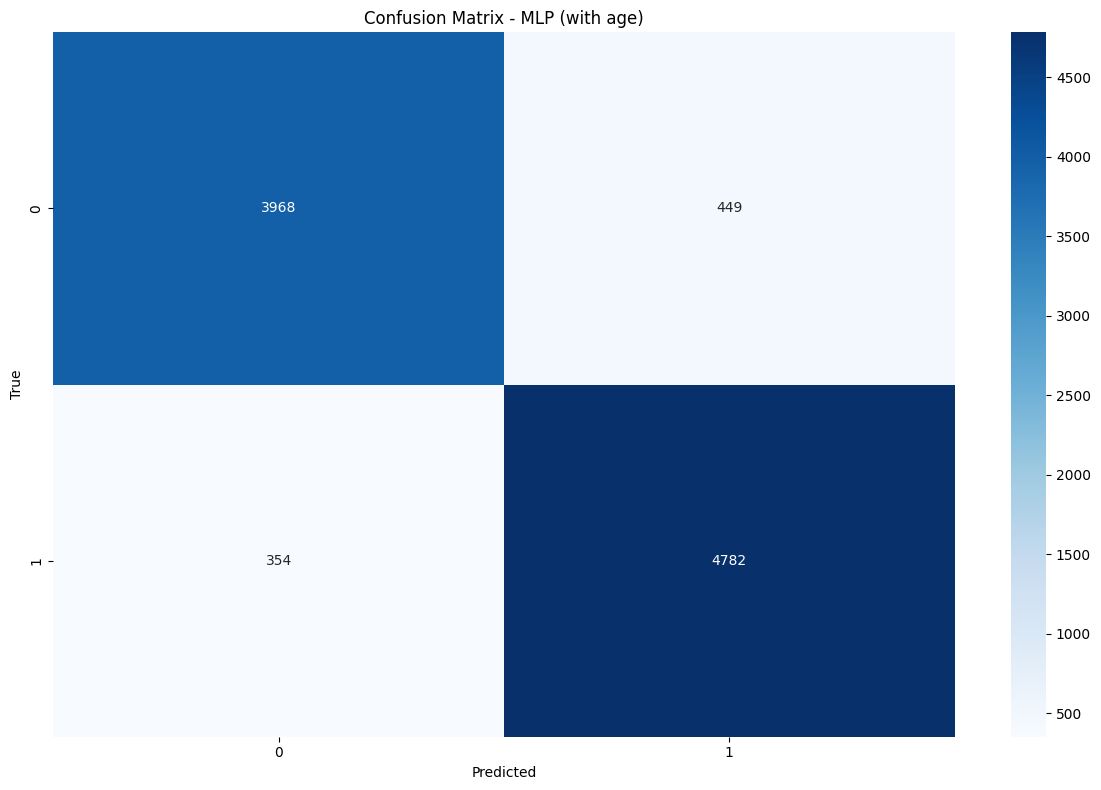

<Figure size 1000x600 with 0 Axes>

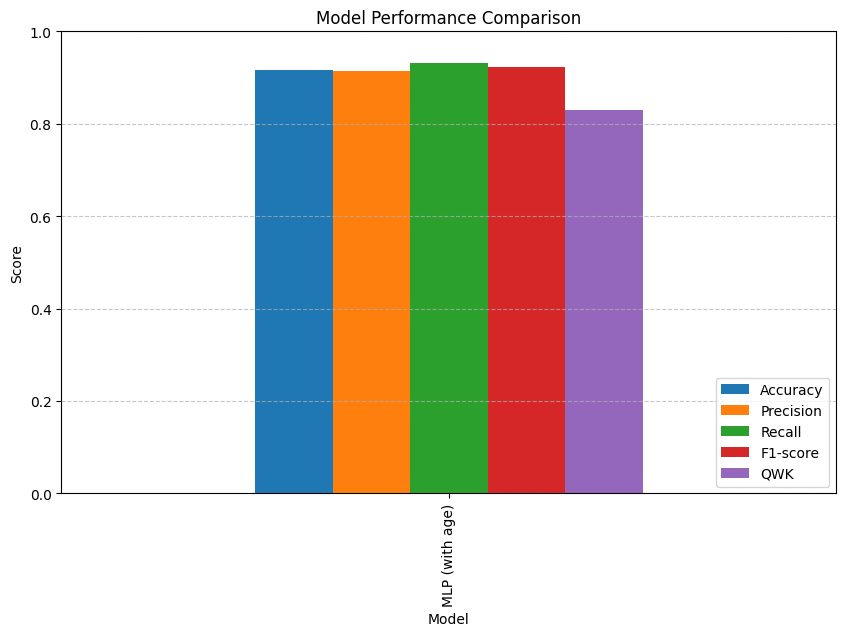

,Model,Accuracy,Precision,Recall,F1-score,QWK,MAE
0,MLP (with age),0.915943,0.914166,0.931075,0.922543,0.830673,0.084057


In [28]:
# run mlp for dataset with age!

fit_pipeline_predict_evaluate(
    MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        max_iter=2000,
        alpha=0.001,
        learning_rate_init=0.0005,
        random_state=27,
        learning_rate='adaptive',
    ),
    "MLP (with age)",
    X_with_age_train,
    X_with_age_val,
    y_train,
    y_val,
    preprocessing
)


Evaluating MLP (without age) on training set...

===== MLP (without age): Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17668
           1       1.00      1.00      1.00     20543

    accuracy                           1.00     38211
   macro avg       1.00      1.00      1.00     38211
weighted avg       1.00      1.00      1.00     38211

QWK: 1.0
MAE: 0.0
Evaluating MLP (without age) on validation set...

===== MLP (without age): Validation Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4417
           1       0.92      0.91      0.91      5136

    accuracy                           0.91      9553
   macro avg       0.91      0.91      0.91      9553
weighted avg       0.91      0.91      0.91      9553

QWK: 0.8153847804833462
MAE: 0.09180362189887993


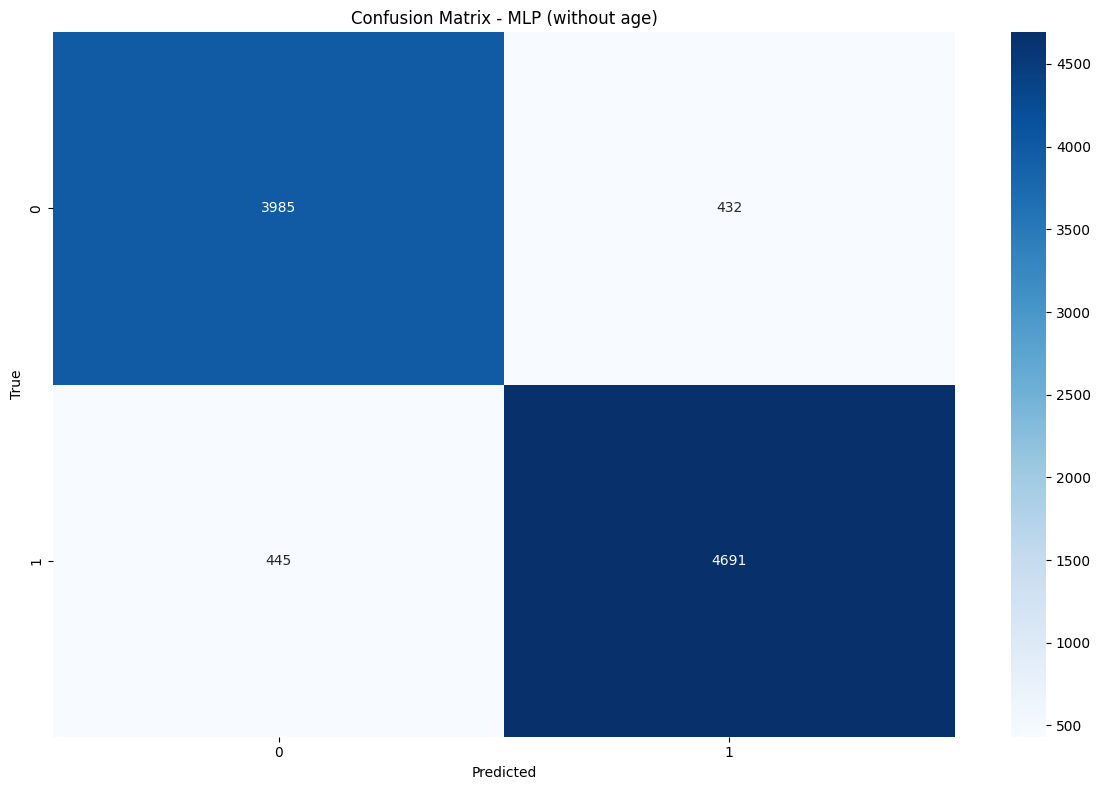

<Figure size 1000x600 with 0 Axes>

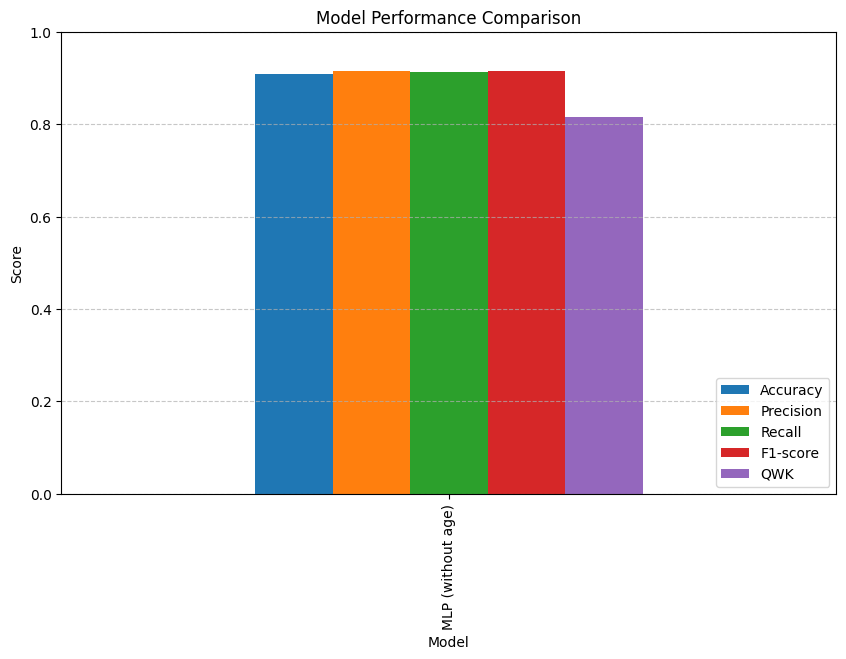

,Model,Accuracy,Precision,Recall,F1-score,QWK,MAE
0,MLP (without age),0.908196,0.915674,0.913357,0.914514,0.815385,0.091804


In [ ]:
# fit mlp model without age param

fit_pipeline_predict_evaluate(
    MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        max_iter=2000,
        alpha=0.001,
        learning_rate_init=0.0005,
        random_state=27,
        learning_rate='adaptive',
    ),
    "MLP (without age)",
    X_without_age_train,
    X_without_age_val,
    y_train,
    y_val,
    preprocessing
)


Evaluating HistGradientBoosting (with age) on training set...

===== HistGradientBoosting (with age): Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     17668
           1       0.96      0.96      0.96     20543

    accuracy                           0.95     38211
   macro avg       0.95      0.95      0.95     38211
weighted avg       0.95      0.95      0.95     38211

QWK: 0.9080386757976601
MAE: 0.045719818900316664
Evaluating HistGradientBoosting (with age) on validation set...

===== HistGradientBoosting (with age): Validation Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4417
           1       0.92      0.92      0.92      5136

    accuracy                           0.91      9553
   macro avg       0.91      0.91      0.91      9553
weighted avg       0.91      0.91      0.91      9553

QWK

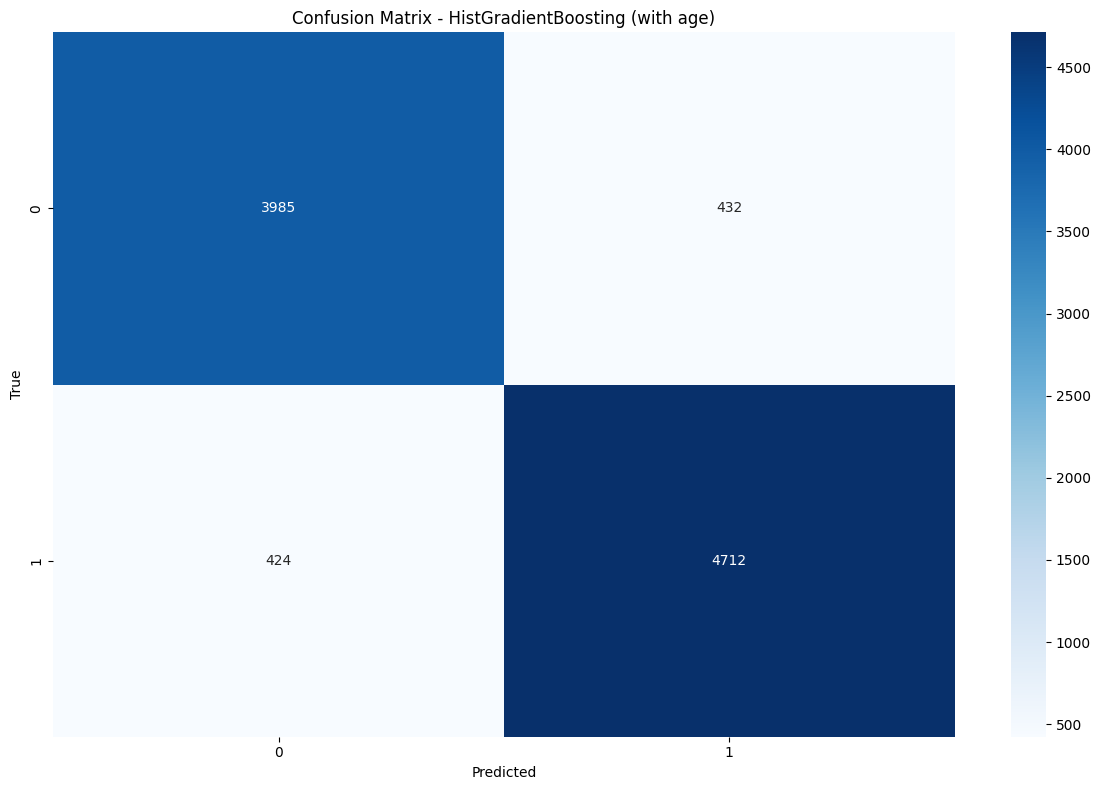

<Figure size 1000x600 with 0 Axes>

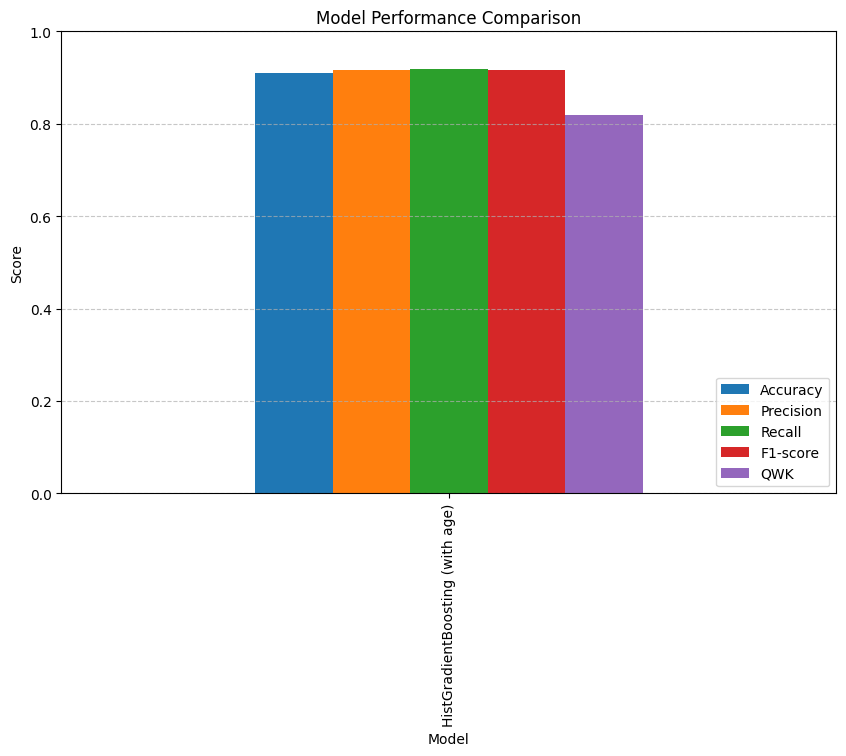

,Model,Accuracy,Precision,Recall,F1-score,QWK,MAE
0,HistGradientBoosting (with age),0.910395,0.916019,0.917445,0.916732,0.819745,0.089605


In [31]:
# Gradient boosting with age

fit_pipeline_predict_evaluate(
    HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_iter=200,
        max_depth=6,
        random_state=27
    ),
    "HistGradientBoosting (with age)",
    X_with_age_train,
    X_with_age_val,
    y_train,
    y_val,
    preprocessing
)


Evaluating HistGradientBoosting (without age) on training set...

===== HistGradientBoosting (without age): Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17668
           1       0.95      0.95      0.95     20543

    accuracy                           0.95     38211
   macro avg       0.95      0.95      0.95     38211
weighted avg       0.95      0.95      0.95     38211

QWK: 0.8947910058617662
MAE: 0.0523147784669336
Evaluating HistGradientBoosting (without age) on validation set...

===== HistGradientBoosting (without age): Validation Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      4417
           1       0.91      0.91      0.91      5136

    accuracy                           0.90      9553
   macro avg       0.90      0.90      0.90      9553
weighted avg       0.90      0.90      0.90     

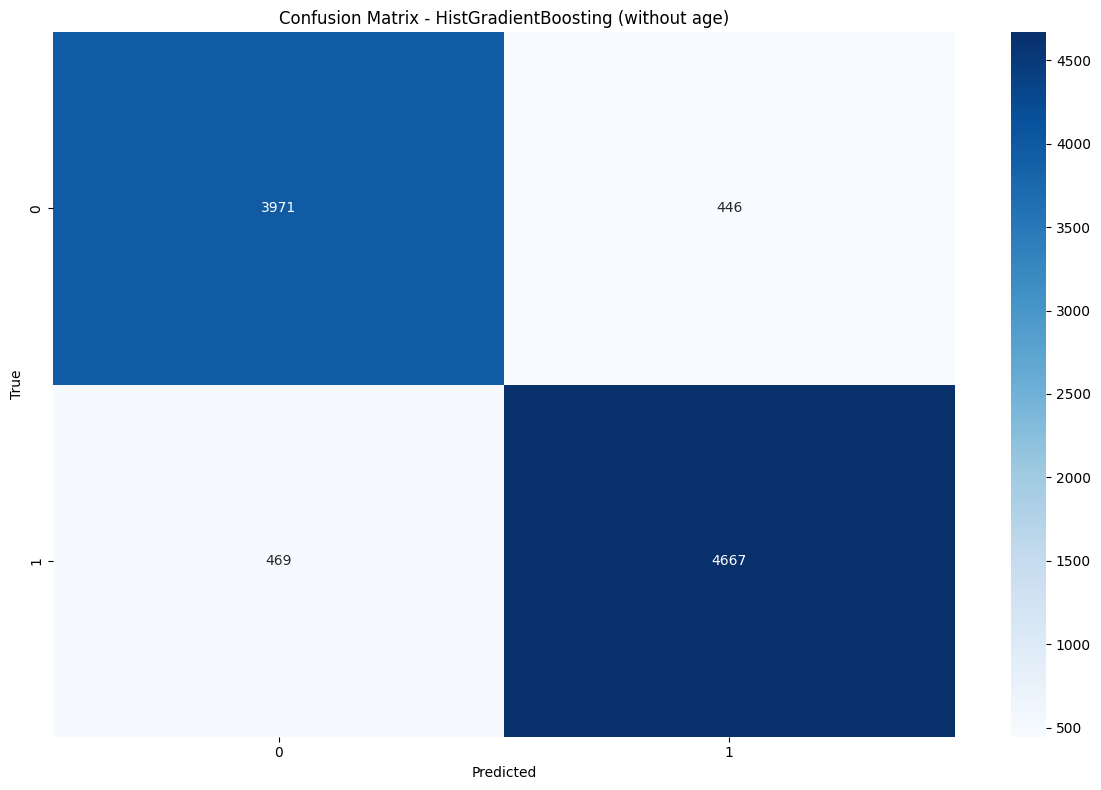

<Figure size 1000x600 with 0 Axes>

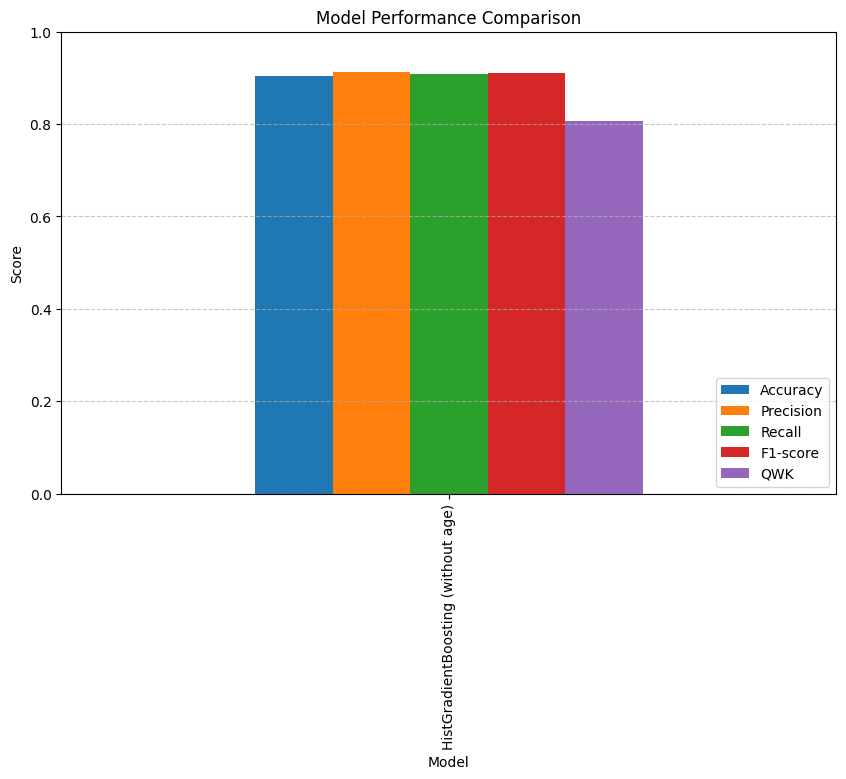

,Model,Accuracy,Precision,Recall,F1-score,QWK,MAE
0,HistGradientBoosting (without age),0.904219,0.912771,0.908684,0.910723,0.807416,0.095781


In [32]:
# Hist Gradient boosting without age

fit_pipeline_predict_evaluate(
    HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_iter=200,
        max_depth=6,
        random_state=27
    ),
    "HistGradientBoosting (without age)",
    X_without_age_train,
    X_without_age_val,
    y_train,
    y_val,
    preprocessing
)